In [0]:
import torch 
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix 
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d


%matplotlib inline

In [0]:
class BasicModule(nn.Module):
    """
    basic block with identity maps in shortcuts
    """
    def __init__(self, in_planes,out_planes, stride = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, padding=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.shortcut = nn.Sequential()
        if stride!=1 or in_planes!=out_planes :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
        
    
    def forward(self, x):
        
        added = x
        
        x = F.celu(self.bn1(self.conv1(x)),alpha=0.075)
        x = self.bn2(self.conv2(x))
        x += self.shortcut(added)
        return F.celu(x,alpha= 0.075)


In [0]:
class BottleNeckModule(nn.Module):
    """
    basic block with identity maps in shortcuts
    """
    def __init__(self, in_planes,out_planes, stride = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, 1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes, 1, padding=0, bias=False, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride!=1 or in_planes!=out_planes:
          self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_planes)
            
            )
    def forward(self, x):
        
        added = x
        x = F.celu(self.bn1(self.conv1(x)),alpha = 0.075)
        x = F.celu(self.bn2(self.conv2(x)),alpha = 0.075)
        x = self.bn3(self.conv3(x))
        inter = self.shortcut(added)
        x+=inter
        x = F.celu(x,alpha = 0.075)
        return x

In [0]:
class ResNet(nn.Module):

  def __init__(self,block,filter_map,n,num_classes=10):

    super().__init__()

    self.conv1  = nn.Conv2d(in_channels=3,out_channels=filter_map[0],kernel_size=3,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(filter_map[0])
    self.block1 = self.MakeResNetLayer(block,filter_map[0],n,stride=1)
    #self.drop1  = nn.Dropout2d(0.3)
    self.block2 = self.MakeResNetLayer(block,(filter_map[0],filter_map[1]),n,stride=2)
    #self.drop2  = nn.Dropout2d(0.2)
    self.block3 = self.MakeResNetLayer(block,(filter_map[1],filter_map[2]),n,stride=2)
    self.drop3  = nn.Dropout2d(0.25)
    self.globalavgpool = nn.AdaptiveAvgPool2d(2)

    #self.drop1  = nn.Dropout(0.3)
    self.fc = nn.Linear(2*2*filter_map[2],num_classes)  

  def MakeResNetLayer(self,block,filters,n,stride):

    if stride!=1 :
      in_planes,out_planes = filters
    else :
      in_planes,out_planes = filters,filters

    layer = []
    layer.append(block(in_planes,out_planes,stride))

    for i in range(n-1):

      layer.append(block(out_planes, out_planes))

    SubBlock = nn.Sequential(*layer)

    return SubBlock

  def  forward(self,x):

    x = F.relu(self.bn1(self.conv1(x)))
        
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
        
    x = self.globalavgpool(x)
    x = x.view(-1, self.find_shape(x))
    x = self.fc(x)
    return x

  def find_shape(self, x):
    res = 1
    for dim in x[0].shape:
        res *= dim
    return res          

In [0]:
batch_size = 128

transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
print(trainset)
print(testset)
print(len(trainloader))
print(len(testloader))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.7)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
391
79


In [0]:
modelbasic = ResNet(BasicModule, [16,32,64], 5)
modelbottleneck = ResNet(BottleNeckModule, [16,32,64], 5)

In [0]:
torch.cuda.device_count() # sadly,we only have one gpu allocated to us 

1

In [0]:
device = 'cuda'
modelbasic.to(device)
modelbottleneck.to(device)
summary(modelbasic,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
       BasicModule-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
      BasicModule-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [0]:
summary(modelbottleneck,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             256
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  BottleNeckModule-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             256
      BatchNorm2d-11           [-1, 16, 32, 32]              32
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
           Conv2d-14           [-1, 16,

In [0]:
epochs =90
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = torch.optim.Adam(modelbasic.parameters(), lr = learning_rate,weight_decay = 2.25e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50,80],gamma = 0.1)

In [0]:
print('test and training loss/accuracy for basic model')
modelbasic.train()


start_time = time.time()

train_losses_basic = np.array([])
test_losses_basic = np.array([])
train_correct_basic = np.array([])
test_correct_basic = np.array([])

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(trainloader):
        b+=1
        
        # Apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = modelbasic(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Print interim results
        if b%256 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{128*b:6}/50000]  loss: {loss.item():10.8f}   accuracy: {(batch_corr.item()*100/128):10.8f}%',end=' ')
        
    np.append(train_losses_basic,loss.item())
    np.append(train_correct_basic,trn_corr.item()/500)
    
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(testloader):
          
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Apply the model
            y_val = modelbasic(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            batch_corr = (predicted == y_test).sum()  
            tst_corr+=batch_corr
            if b==40 :
              print(f'test accuracy :{batch_corr.item()*100/128}% ')

    loss = criterion(y_val, y_test)
    np.append(test_losses_basic,loss.item())
    np.append(test_correct_basic,tst_corr.item()/100)    
print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed  ,minutes') # print the time elapsed




test and training loss/accuracy for basic model
epoch:  0  batch:  256 [ 32768/50000]  loss: 1.40607643   accuracy: 43.75000000% test accuracy :42.96875% 
epoch:  1  batch:  256 [ 32768/50000]  loss: 1.40810227   accuracy: 48.43750000% test accuracy :52.34375% 
epoch:  2  batch:  256 [ 32768/50000]  loss: 1.29086232   accuracy: 50.78125000% test accuracy :51.5625% 
epoch:  3  batch:  256 [ 32768/50000]  loss: 0.85752791   accuracy: 68.75000000% test accuracy :65.625% 
epoch:  4  batch:  256 [ 32768/50000]  loss: 1.12198818   accuracy: 60.15625000% test accuracy :66.40625% 
epoch:  5  batch:  256 [ 32768/50000]  loss: 0.88792193   accuracy: 67.96875000% test accuracy :66.40625% 
epoch:  6  batch:  256 [ 32768/50000]  loss: 0.68238086   accuracy: 75.78125000% test accuracy :68.75% 
epoch:  7  batch:  256 [ 32768/50000]  loss: 0.75854486   accuracy: 72.65625000% test accuracy :69.53125% 
epoch:  8  batch:  256 [ 32768/50000]  loss: 0.93977696   accuracy: 65.62500000% test accuracy :75.0% 

KeyboardInterrupt: ignored

In [0]:
optimizer = torch.optim.Adam(modelbottleneck.parameters(), lr = learning_rate,weight_decay = 2.5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50,75],gamma = 0.1)

In [0]:
 print('test and training loss/accuracy for bottleneck model')
modelbottleneck.train()


  
start_time = time.time()


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(trainloader):
        b+=1
        
        # Apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = modelbottleneck(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()          
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Print interim results
        if b%256== 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/50000]  loss: {loss.item():10.8f}   accuracy: {(batch_corr.item()*100/128):10.8f}%',end=' ')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(testloader):
          
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Apply the model
            y_val = modelbottleneck(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            batch_corr = (predicted == y_test).sum()              
            tst_corr += (predicted == y_test).sum()
            if b==40 :
              print(f'test accuracy :{batch_corr.item()*100/128}% ')
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())   

print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed  ,minutes') # print the time elapsed 
train_loss_bottleneck = np.array(train_losses)
test_loss_bottleneck = np.array(test_losses)
train_correct_bottleneck = np.array(train_correct)/500
test_correct_bottleneck = np.array(test_correct)/100

test and training loss/accuracy for bottleneck model
epoch:  0  batch:  256 [ 25600/50000]  loss: 2.23069358   accuracy: 20.31250000% test accuracy :17.96875% 
epoch:  1  batch:  256 [ 25600/50000]  loss: 2.13860202   accuracy: 15.62500000% test accuracy :28.125% 
epoch:  2  batch:  256 [ 25600/50000]  loss: 1.91126108   accuracy: 25.78125000% test accuracy :35.15625% 
epoch:  3  batch:  256 [ 25600/50000]  loss: 1.90271389   accuracy: 27.34375000% test accuracy :31.25% 
epoch:  4  batch:  256 [ 25600/50000]  loss: 1.72290170   accuracy: 36.71875000% test accuracy :35.9375% 
epoch:  5  batch:  256 [ 25600/50000]  loss: 1.69307446   accuracy: 35.93750000% test accuracy :48.4375% 
epoch:  6  batch:  256 [ 25600/50000]  loss: 1.74344540   accuracy: 33.59375000% test accuracy :42.1875% 
epoch:  7  batch:  256 [ 25600/50000]  loss: 1.62921083   accuracy: 39.06250000% test accuracy :43.75% 
epoch:  8  batch:  256 [ 25600/50000]  loss: 1.47756541   accuracy: 45.31250000% test accuracy :45.312

KeyboardInterrupt: ignored

Text(0, 0.5, 'Accuracy')

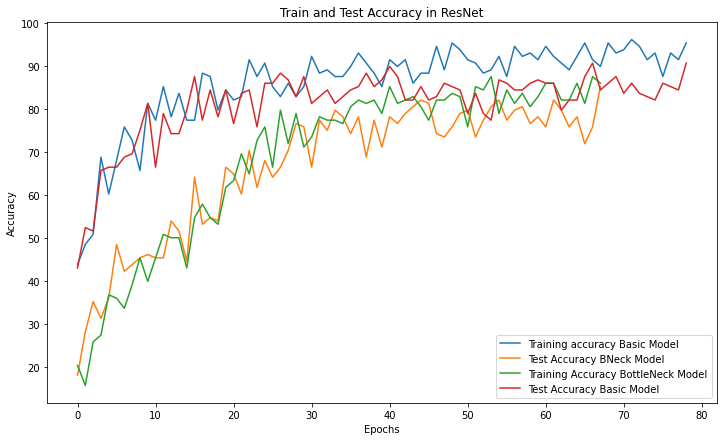

In [0]:
result_basic = pd.read_csv('results.csv')
result_bottleneck = pd.read_csv('results_bn.csv')
plt.figure(figsize=(12,7))
plt.title("Train and Test Accuracy in ResNet")
palette_basic = sns.color_palette(palette="muted",n_colors=2)
palette_bottleneck = sns.color_palette(palette="dark",n_colors=2)
sns.lineplot(data = result_basic['train_accuracy'],label="Training accuracy Basic Model",palette=palette_basic)
sns.lineplot(data = result_bottleneck['test_accuracy'],label="Test Accuracy BNeck Model",palette=palette_bottleneck)
sns.lineplot(data = result_bottleneck['train_accuracy'] ,label="Training Accuracy BottleNeck Model",palette=palette_bottleneck)
sns.lineplot(data = result_basic['test_accuracy'],label="Test Accuracy Basic Model",palette=palette_basic)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [0]:
plt.figure(figsize=(12,7))
plt.title("Train and Test losses in ResNet")
palette_basic = sns.color_palette(palette="muted",n_colors=2)
palette_bottleneck = sns.color_palette(palette="dark",n_colors=2)
sns.lineplot(data = result_basic['loss'],label="Training loss Basic Model",palette=palette_basic)
sns.lineplot(data = result_bottleneck['loss'],label="Test Loss BNeck Model",palette=palette_bottleneck)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Test accuracy Basic: 8553/10000 =  85.530%


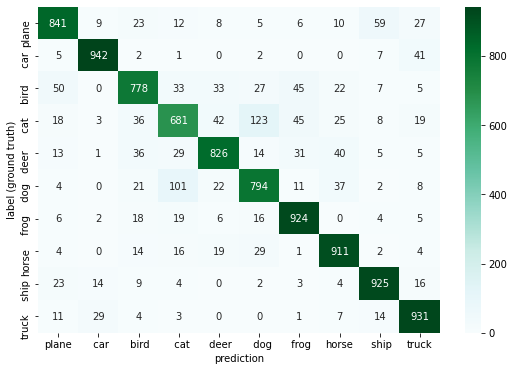

Test accuracy BottleNeck: 8006/10000 =  80.060%


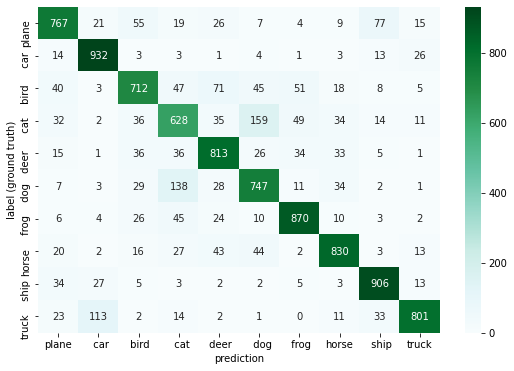

In [0]:
test_load_all = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = modelbasic(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')

class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

test_load_all = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = modelbottleneck(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy BottleNeck: {correct.item()}/{len(testset)} = {correct.item()*100/len(testset):7.3f}%')

arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()
